In [1]:
import matplotlib.pyplot as plt
import nnfs
import numpy as np
from nnfs.datasets import spiral_data

In [2]:
nnfs.init()
plt.style.use('seaborn-v0_8-bright')

In [19]:
class Model:

    def __init__(self, epochs):
        self.dense_layers = []
        self.epochs = epochs
        self.optimizer = None
        self.X = None
        self.y = None

    def add_dense(self, n_inputs, n_neurons, activation):
        dense = Dense(n_inputs, n_neurons, activation)
        self.dense_layers.append(dense)

    def add_loss(self, loss_function):
        self.loss_function = loss_function()

    def add_optimizer(self, optimizer, **params):
        self.optimizer = optimizer(**params)

    def fit(self, X, y):
        self.X = X
        self.y = y
        for epoch in range(self.epochs):

            layer_output = self.X
            for layer in self.dense_layers:
                layer_output = layer.forward(layer_output)

            loss = self.loss_function.calculate(layer_output, self.y)
            predictions = np.argmax(layer_output, axis=1)
            if len(self.y.shape) == 2:
                self.y = np.argmax(self.y, axis=1)
            accuracy = np.mean(predictions == self.y)
            if not epoch % 100:
                print(
                    f"Epochs: {epoch}, Acc: {accuracy}, Loss: {loss}, Lr: {self.optimizer.current_learning_rate}"
                )

            dvalues = self.loss_function.backward(layer_output, self.y)
            for layer in self.dense_layers[::-1]:
                dvalues = layer.backward(dvalues)
            self.optimizer.pre_update_params()
            for layer in self.dense_layers:

                self.optimizer.update_params(layer)
            self.optimizer.post_update_params()

    def show_boundary(self):
        h = 0.02
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        layer_output = np.c_[xx.ravel(), yy.ravel()]
        for layer in self.dense_layers:
            layer_output = layer.forward(layer_output)

        Z = np.argmax(layer_output, axis=1)

        print(Z)
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                             np.arange(y_min, y_max, 0.1))
        layer_output = np.c_[xx.ravel(), yy.ravel()]
        for layer in self.dense_layers:
            layer_output = layer.forward(layer_output)
        Z = np.argmax(layer_output, axis=1).reshape(xx.shape)

        print(Z.shape)
        plt.contourf(xx, yy, Z, alpha=0.2)
        plt.scatter(X[:, 0], X[:, 1], c=y, alpha=1)

In [4]:
class Dense:

    def __init__(self, n_inputs, n_neurons, activation):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.activation = activation()

    def forward(self, inputs):
        self.inputs = inputs
        self.output = self.activation.forward(
            np.dot(self.inputs, self.weights) + self.biases)
        return self.output

    # dvalues is derivative we got from previous neurons
    def backward(self, dvalues):
        dvalues = self.activation.backward(dvalues)
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)
        return self.dinputs

In [5]:
class ReLU:

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        return self.dinputs


class Softmax:

    def forward(self, inputs):
        self.inputs = inputs
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return self.output

    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        for index, (single_output,
                    single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(1, -1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(
                single_output.T, single_output)

            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)
        return self.dinputs

In [66]:
class Loss:

    def calculate(self, y_pred, y_actual):
        sample_losses = self.forward(y_pred, y_actual)
        data_loss = np.mean(sample_losses)
        return data_loss


class Categorical_Cross_Entropy(Loss):

    def forward(self, y_pred, y_actual):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        correct_confidences = []
        if len(y_actual.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_actual]
        elif len(y_actual.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_actual, axis=1)
        negative_log = -np.log(correct_confidences)
        return negative_log

    def backward(self, dvalues, y_true):

        samples = len(dvalues)
        labels = len(dvalues[0])
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        # dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples
        return self.dinputs


class Softmax_Activation_Categorical_Cross_Entropy_Loss:

    def __init__(self):
        self.activation = Softmax()
        self.loss = Categorical_Cross_Entropy()

    def forward(self, inputs, y_actual):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_actual)

    def backward(self, dvalues, y_actual):
        samples = len(dvalues)
        if len(y_actual.shape) == 2:
            y_actual = np.argmax(y_actual, axis=1)

        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_actual] -= 1
        self.dinputs = self.dinputs / samples
        return self.dinputs

In [52]:
class SGD:

    def __init__(self, learning_rate=1, decay=0.0, momentum=0.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.momentum = momentum
        self.iterations = 0

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (
                1.0 / (1.0 + self.decay * self.iterations))

    def update_params(self, layer):
        if self.momentum:
            if not hasattr(layer, "weight_momentums"):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            weight_update = (self.momentum * layer.weight_momentums -
                             self.current_learning_rate * layer.dweights)
            layer.weight_momentums = weight_update

            bias_update = (self.momentum * layer.bias_momentums -
                           self.current_learning_rate * layer.dbiases)
            layer.bias_momentums = bias_update
        else:
            weight_update = -self.current_learning_rate * layer.dweights
            bias_update = -self.current_learning_rate * layer.dbiases

        layer.weights += weight_update
        layer.biases += bias_update

    def post_update_params(self):
        self.iterations += 1


class AdaGrad:

    def __init__(self, learning_rate=0.1, decay=0.0, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.epsilon = epsilon
        self.iterations = 0

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (
                1.0 / (1.0 + self.decay * self.iterations))

    def update_params(self, layer):

        if not hasattr(layer, "weight_cache"):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        layer.weight_cache += layer.dweights**2

        layer.bias_cache += layer.dbiases**2

        layer.weights += ((-self.current_learning_rate * layer.dweights) /
                          (np.sqrt(layer.weight_cache) + self.epsilon))
        layer.biases += ((-self.current_learning_rate * layer.dbiases) /
                         (np.sqrt(layer.bias_cache) + self.epsilon))
        # print(self.current_learning_rate)
        # print(self.iterations)

    def post_update_params(self):
        self.iterations += 1


class RMSProp:

    def __init__(self, learning_rate=0.01, decay=0.0, epsilon=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (
                1.0 / (1.0 + self.decay * self.iterations))

    def update_params(self, layer):
        if not hasattr(layer, "weight_cache"):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        layer.weight_cache = self.rho * layer.weight_cache + (
            1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + (
            1 - self.rho) * layer.dbiases**2
        layer.weights += ((-self.current_learning_rate * layer.dweights) /
                          (np.sqrt(layer.weight_cache) + self.epsilon))
        layer.biases += ((-self.current_learning_rate * layer.dbiases) /
                         (np.sqrt(layer.bias_cache) + self.epsilon))

    def post_update_params(self):
        self.iterations += 1

In [63]:
X, y = spiral_data(samples=100, classes=3)

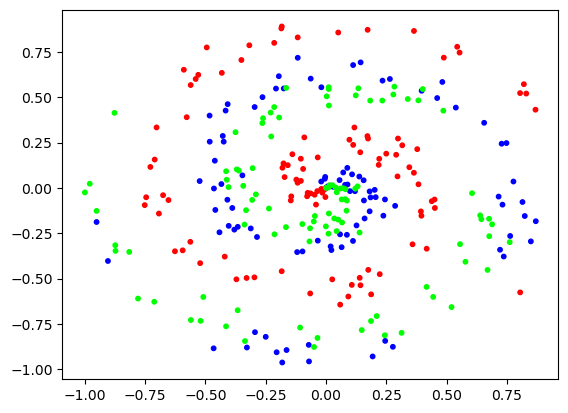

In [64]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap="brg")

In [67]:
model = Model(10001)
model.add_dense(2, 64, ReLU)
model.add_dense(64, 3, Softmax)
model.add_loss(Categorical_Cross_Entropy)
model.add_optimizer(RMSProp, learning_rate=0.01, decay=1e-6, rho=0.999)
model.fit(X, y)

Epochs: 0, Acc: 0.38, Loss: 1.098601222038269, Lr: 0.01
Epochs: 100, Acc: 0.44666666666666666, Loss: 1.0029230117797852, Lr: 0.009999010098000298
Epochs: 200, Acc: 0.5233333333333333, Loss: 0.9398472309112549, Lr: 0.00999801039593121
Epochs: 300, Acc: 0.5966666666666667, Loss: 0.880974531173706, Lr: 0.009997010893742771
Epochs: 400, Acc: 0.6766666666666666, Loss: 0.8331179022789001, Lr: 0.009996011591375042
Epochs: 500, Acc: 0.65, Loss: 0.8066986203193665, Lr: 0.009995012488768105
Epochs: 600, Acc: 0.6833333333333333, Loss: 0.7561067938804626, Lr: 0.009994013585862068
Epochs: 700, Acc: 0.69, Loss: 0.7402879595756531, Lr: 0.009993014882597065
Epochs: 800, Acc: 0.6866666666666666, Loss: 0.7267087697982788, Lr: 0.00999201637891325
Epochs: 900, Acc: 0.7, Loss: 0.6888623833656311, Lr: 0.0099910180747508
Epochs: 1000, Acc: 0.6966666666666667, Loss: 0.6764093041419983, Lr: 0.00999001997004992
Epochs: 1100, Acc: 0.73, Loss: 0.6353848576545715, Lr: 0.009989022064750839
Epochs: 1200, Acc: 0.7333

[2 2 2 ... 1 1 1]
(39, 39)


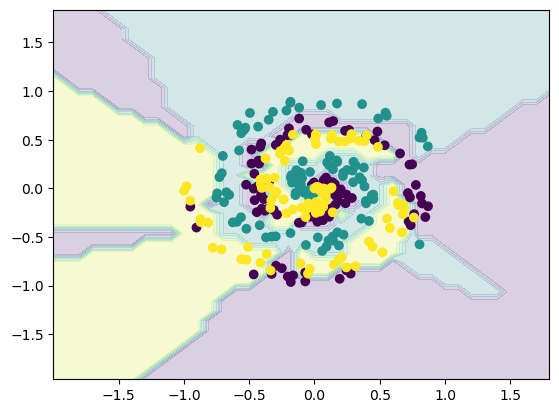

In [69]:
model.show_boundary()

In [ ]:
# X = np.array([[0.7, 0.1, 0.21], [0.1, 0.5, 0.4], [0.02, 0.9, 0.08]])
# y = np.array([0, 1, 1])

# softmax_loss = Softmax_Activation_Categorical_Cross_Entropy_Loss()
# print(X, y)
# softmax_loss.backward(X, y)
# dvalues1 = softmax_loss.dinputs

# activation = Softmax_Activation()
# activation.output = X
# loss = Categorical_Cross_Entropy_Loss()
# loss.backward(X, y)
# print(loss.dinputs)
# activation.backward(loss.dinputs)
# dvalues2 = activation.dinputs

# print("Gradients: combined loss and activation:")
# print(dvalues1)
# print("Gradients: separate loss and activation:")
# print(dvalues2)

In [ ]:
# dense_1 = Dense(2, 64)
# activation_1 = ReLU_Activation()

# dense_2 = Dense(64, 3)
# activation_2 = Softmax_Activation()

# loss_function = Categorical_Cross_Entropy_Loss()

# optimizer = SGD_Optimizer()
# for epoch in range(1000):
#     dense_1.forward(X)
#     activation_1.forward(dense_1.output)
#     dense_2.forward(activation_1.output)
#     activation_2.forward(dense_2.output)
#     loss = loss_function.calculate(activation_2.output, y)

#     # print("Softmax Forward : ", activation_2.output)
#     predictions = np.argmax(activation_2.output, axis=1)
#     if len(y.shape) == 2:
#         y = np.argmax(y, axis=1)

#     accuracy = np.mean(predictions == y)
#     # if not epoch % 100:
#     print(f"Epochs: {epoch}, Acc: {accuracy}, Loss: {loss}")

#     loss_function.backward(activation_2.output, y)
#     # print(loss_function.dinputs.shape)
#     activation_2.backward(loss_function.dinputs)
#     # print("Softmax backward : ", activation_2.dinputs)

#     dense_2.backward(activation_2.dinputs)
#     activation_1.backward(dense_2.dinputs)
#     dense_1.backward(activation_1.dinputs)

#     optimizer.update_params(dense_1)
#     # print(dense_1.weights)
#     optimizer.update_params(dense_2)
#     # print(dense_2.biases)

In [ ]:
# dense_1 = Dense(2, 64)
# activation_1 = ReLU_Activation()

# dense_2 = Dense(64, 3)
# activation_2 = Softmax_Activation_Categorical_Cross_Entropy_Loss()

# sgd = SGD_Optimizer()
# for epoch in range(20):
#     dense_1.forward(X)
#     activation_1.forward(dense_1.output)
#     dense_2.forward(activation_1.output)

#     loss = activation_2.forward(dense_2.output, y)

#     # print("Softmax Forward : ", activation_2.output)

#     predictions = np.argmax(activation_2.output, axis=1)
#     if len(y.shape) == 2:
#         y = np.argmax(y, axis=1)

#     accuracy = np.mean(predictions == y)
#     # if not epoch % 100:
#     print(f"Epochs: {epoch}, Acc: {accuracy}, Loss: {loss}")

#     activation_2.backward(activation_2.output, y)
#     print("Softmax backward : ", activation_2.dinputs)

#     dense_2.backward(activation_2.dinputs)
#     activation_1.backward(dense_2.dinputs)
#     dense_1.backward(activation_1.dinputs)

#     sgd.update_params(dense_1)
#     # print(dense_1.weights)
#     sgd.update_params(dense_2)